# Question 2
## Part a.
### GRU Model

This model was built using code from the lab notebooks for the EIRNN, but adapting it into a GRU. This means the main model classes are much more simplified in comparison. The structure of having the GRURNN class and GRUNet class separately isn't necessary, but it matches the method used for the EIRNN, thereby simplifying the implementation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import math
import logging
import neurogym as ngym
import matplotlib.pyplot as plt
import torch.optim as optim
import neurogym as ngym
import logging
import pandas as pd

In [39]:
class GRURNN(nn.Module):
    """GRU Recurrent Neural Network.

    Parameters:
        input_size: Number of input features
        hidden_size: Number of hidden units in the GRU
        num_layers: Number of stacked GRU layers (optional, default=1)
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Use PyTorch's built-in GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=0.2)

    def forward(self, input, hidden=None):
        """Propagate input through the GRU."""
        # Forward pass through GRU
        output, hidden = self.gru(input, hidden)
        return output, hidden

In [40]:
# ----------------------------- GRU Model implementation -----------------------------
# Define GRUNet as the full model
class GRUNet(nn.Module):
    """Recurrent Network Model using GRU.

    Parameters:
        input_size: Number of input features
        hidden_size: Number of hidden units in the GRU
        output_size: Number of output features
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        # Replace LeakyRNN with GRURNN
        self.rnn = GRURNN(input_size, hidden_size, num_layers=num_layers)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Process the sequence through the GRU
        rnn_output, _ = self.rnn(x)

        # Map the GRU output to the output space
        out = self.fc(rnn_output)
        return out, rnn_output

In [41]:
# Ensure `PerceptualDecisionMakingDelayResponse` is registered in NeuroGym
task = 'PerceptualDecisionMakingDelayResponse-v0'

# Define timing and environment parameters
timing = {
    'fixation': 500,
    'stimulus': 1000,
    'delay': 1500,
    'decision': 1000,
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 200  # Adjust sequence length to accommodate delay-response structure

# Create dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=32, seq_len=seq_len)

# Environment setup
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [ ]:
# Define GRU model parameters
hidden_size = 200
num_layers = 2

# Instantiate the network
net = GRUNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
print(net)

# Optimizer with weight decay and learning rate scheduler
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
# During training, define the criterion with ignore_index
criterion = nn.CrossEntropyLoss(ignore_index=-1)

loss_values = []  # Store training losses
running_loss = 0.0
print_step = 200

GRUNet(
  (rnn): GRURNN(
    (gru): GRU(3, 200, num_layers=2, dropout=0.2)
  )
  (fc): Linear(in_features=200, out_features=3, bias=True)
)


In [43]:
for i in range(5000):
    # Load batch
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float()
    labels = torch.from_numpy(labels)

    # Map labels 1 -> 0, 2 -> 1; handle NaN labels
    labels = torch.where(labels == 1, torch.tensor(0), labels)
    labels = torch.where(labels == 2, torch.tensor(1), labels)
    labels = torch.where(labels.isnan(), torch.tensor(-100), labels)
    labels = labels.type(torch.long)

    # Normalise inputs
    inputs = (inputs - inputs.mean()) / (inputs.std() + 1e-7)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)
    labels = labels.view(-1)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass and gradient clipping
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimizer.step()

    # Log running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print(f'Step {i+1}, Loss {average_loss:.4f}')
        loss_values.append(average_loss)
        running_loss = 0.0

Step 200, Loss 0.3663
Step 400, Loss 0.1969
Step 600, Loss 0.1892
Step 800, Loss 0.1853
Step 1000, Loss 0.1830
Step 1200, Loss 0.1797
Step 1400, Loss 0.1402
Step 1600, Loss 0.0865
Step 1800, Loss 0.0791
Step 2000, Loss 0.0771
Step 2200, Loss 0.0769
Step 2400, Loss 0.0721
Step 2600, Loss 0.0679
Step 2800, Loss 0.0684
Step 3000, Loss 0.0706
Step 3200, Loss 0.0652
Step 3400, Loss 0.0662
Step 3600, Loss 0.0648
Step 3800, Loss 0.0668
Step 4000, Loss 0.0666
Step 4200, Loss 0.0649
Step 4400, Loss 0.0615
Step 4600, Loss 0.0644
Step 4800, Loss 0.0680
Step 5000, Loss 0.0637


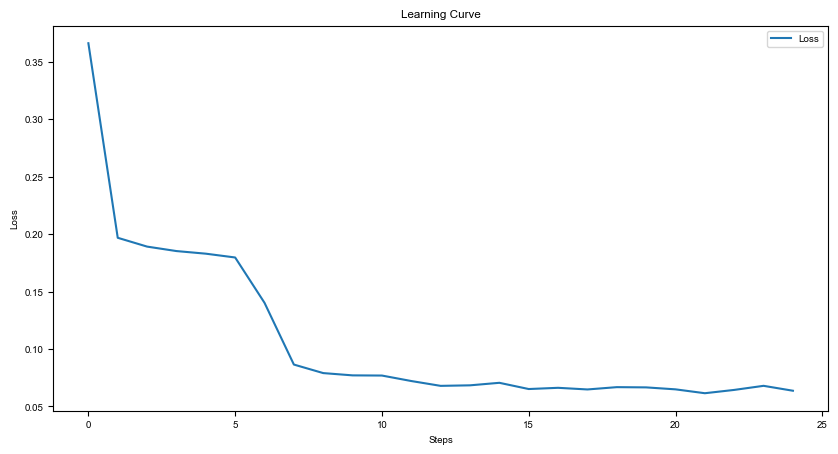

In [44]:
# Plot learning curve
plt.figure(figsize=(10, 5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluation on trials (same as for EIRNN on the same task)
env.reset(no_step=True)
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = {0: [], 1: []}  # Adjusted keys to match labels 0 and 1
delay_activity = {0: [], 1: []}

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).float()
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])  # Now choice is 0 or 1
    gt_label = int(gt[~np.isnan(gt)][-1])
    gt_mapped = gt_label - 1  # Map ground truth labels from {1,2} to {0,1}
    correct = choice == gt_mapped

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice, 'gt_label': gt_label})
    trial_infos[i] = trial_info

    # Log activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Log activity during the stimulus period
    stim_start = env.start_ind['stimulus']
    stim_end = env.end_ind['stimulus']
    stim_activity[gt_mapped].append(rnn_activity[stim_start:stim_end])

    # Log activity during the delay period
    delay_start = env.start_ind['delay']
    delay_end = env.end_ind['delay']
    delay_activity[gt_mapped].append(rnn_activity[delay_start:delay_end])

# Compute average performance
correct_trials = [val['correct'] for val in trial_infos.values()]
accuracy = np.mean(correct_trials)
print(f'Model Average Performance on Delay Response Task: {accuracy * 100:.2f}%')

# Check the number of trials per ground truth label
print(f"Number of trials with ground truth 1: {len(stim_activity[0])}")
print(f"Number of trials with ground truth 2: {len(stim_activity[1])}")

Model Average Performance on Delay Response Task: 49.40%
Number of trials with ground truth 1: 237
Number of trials with ground truth 2: 263


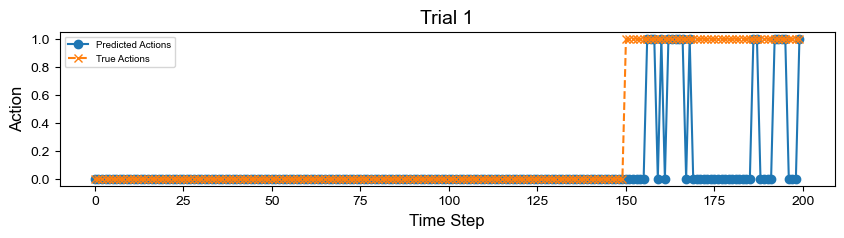

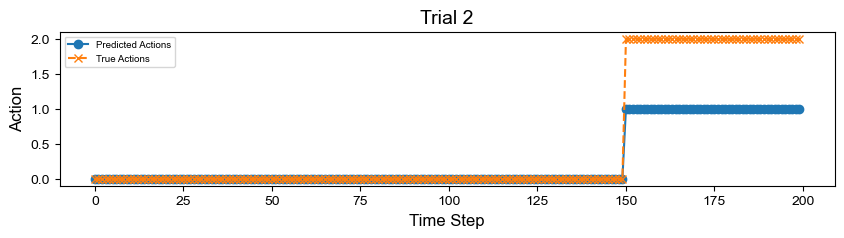

In [ ]:
# Ensure compatibility with dataset output format
with torch.no_grad(): # Disable gradient tracking
    inputs, labels = dataset()  # Unpack the dataset tuple
    inputs = torch.from_numpy(inputs).type(torch.float)  # Convert inputs to PyTorch tensor
    inputs = (inputs - inputs.mean()) / inputs.std()  # Normalise inputs

    preds, _ = net(inputs)  # Pass inputs through the model
    predicted_actions = preds.argmax(dim=-1).cpu().numpy()  # Extract predicted actions

for trial in range(2): # Plot the first two trials
    plt.figure(figsize=(10, 2))
    plt.title(f"Trial {trial + 1}", fontsize=14)
    plt.plot(predicted_actions[:, trial], label='Predicted Actions', marker='o')
    plt.plot(labels[:, trial], label='True Actions', linestyle='--', marker='x')
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Action", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.show()

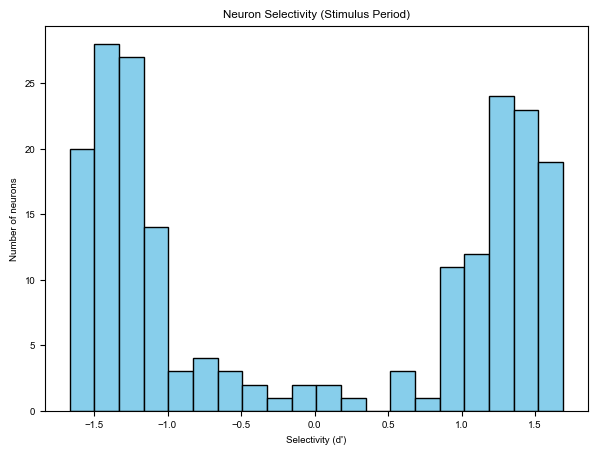

In [ ]:
# Compute stimulus selectivity for neurons
mean_activity = []
std_activity = []
for ground_truth in [0, 1]: # Iterate over ground truth labels (the if else is used to handle empty activity lists)
    if stim_activity[ground_truth]:  # Ensure non-empty activity list
        activity = np.concatenate(stim_activity[ground_truth], axis=0)  # Shape: (total_time_steps, hidden_size)
        mean_activity.append(np.mean(activity, axis=0))  # Mean over time steps
        std_activity.append(np.std(activity, axis=0))    # Std over time steps
    else:
        mean_activity.append(np.zeros(net.rnn.hidden_size)) # Zero mean for empty activity
        std_activity.append(np.ones(net.rnn.hidden_size)) # Unit std for empty activity

# Calculate selectivity (d') for neurons
epsilon = 1e-7  # Small value to prevent division by zero
selectivity = (mean_activity[1] - mean_activity[0])  # Difference between means
selectivity /= np.sqrt((std_activity[0] ** 2 + std_activity[1] ** 2 + epsilon) / 2)  # Pooled standard deviation

# Plot selectivity distribution
plt.figure(figsize=(7, 5)) 
plt.hist(selectivity, bins=20, color="skyblue", edgecolor="black")
plt.title("Neuron Selectivity (Stimulus Period)")
plt.xlabel("Selectivity (d')")
plt.ylabel("Number of neurons")
plt.show()

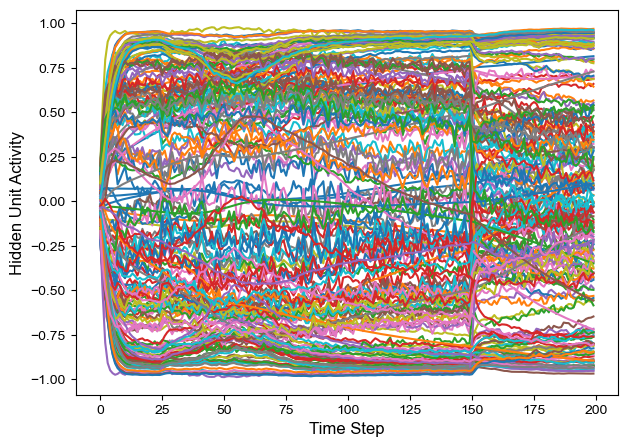

In [ ]:
# Visualise hidden unit activity for a sample trial
trial = 0  # Select a trial to visualize
inputs, _ = dataset() # Load a batch
inputs = torch.from_numpy(inputs).type(torch.float) # Convert inputs to PyTorch tensor

with torch.no_grad(): # Disable gradient tracking
    _, rnn_activity = net(inputs)  # rnn_activity shape: (seq_len, batch_size, hidden_size)

# Extract activity for the selected trial
rnn_activity_trial = rnn_activity[:, trial, :].detach().cpu().numpy()  # Shape: (seq_len, hidden_size)

plt.figure(figsize=(7, 5))
plt.plot(rnn_activity_trial)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Hidden Unit Activity", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()